In [1]:
# Input info
#indir = ""
#cloneID_f = ""
#outdir = "/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clonal_shifts/donors/donor0/variants_init/knn/kparam_30/clones/"
#clone_id = "0_7"
#noIn_indir = "/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clonal_shifts/variants_init/clones/results/noInput/knn/kparam_30/"
#input_indir = "/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clonal_shifts/variants_init/clones/results/inputOnly/knn/kparam_30/"
# params
#p_thresh = 0.1 


indir = "/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clonal_shifts/variants_init/donors/donor1/clones/knn_kparam_3"
outdir = "/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/single_clones/donor1/cloneMethod_variants_init_knn_resolution_3/clonalShift_method_clones/single"
cloneID_f = "/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/single_clones/donor1/cloneMethod_variants_init_knn_resolution_3/clonalShift_method_clones/cloneIDs.txt"




In [2]:

from glob import glob
import pandas as pd
import numpy as np
from os.path import join, exists
import os
from tqdm.notebook import tqdm

from scipy.stats import hypergeom, fisher_exact
from statsmodels.stats import multitest 

import seaborn as sns
import matplotlib.pyplot as plt

from src import clonal_shifts as cs
from icecream import ic

from mplh import cluster_help as ch

fig_utils from mplh


In [3]:
with open(cloneID_f, "r") as f:
    cloneIDs = f.readlines()
cloneIDs = [x.strip() for x in cloneIDs]
cloneIDs

['1_4',
 '1_37',
 '1_18',
 '1_24',
 '1_15',
 '1_5',
 '1_6',
 '1_8',
 '1_10',
 '1_11',
 '1_29',
 '1_14',
 '1_7',
 '1_30',
 '1_13',
 '1_1',
 '1_3',
 '1_0',
 '1_21',
 '1_16',
 '1_28',
 '1_20',
 '1_36',
 '1_25',
 '1_9',
 '1_12',
 '1_2',
 '1_23',
 '1_34',
 '1_27',
 '1_33',
 '1_32',
 '1_19',
 '1_17',
 '1_26',
 '1_22',
 '1_31',
 '1_35']

In [4]:
#cells_meta = pd.read_csv(cells_meta_f, sep="\t")

In [5]:
# noIn_don_indir =  join(noIn_indir,"sepDonors", f"donor{donor}")
# noInput_hyper = pd.read_csv(join(noIn_don_indir, "hypergeo_padjusted.csv"),  index_col=0)

# noIn_don_indir =  join(noIn_indir,"sepDonors", f"donor{donor}")
# noInput_hyper = pd.read_csv(join(noIn_don_indir, "hypergeo_pvals.csv"),  index_col=0)
# noIn_shuffle_df = pd.read_csv(join(noIn_don_indir, "shuffle_results_pvals.tsv"), sep="\t", index_col=0)


# input_don_indir =  join(input_indir,"sepDonors", f"donor{donor}")
# input_hyper = pd.read_csv(join(input_don_indir, "hypergeo_padjusted.csv"), index_col=0)
# input_shuffle_df = pd.read_csv(join(input_don_indir, "shuffle_results_pvals.tsv"), sep="\t", index_col=0)

# input_shuffle_df

noInput_hyper = pd.read_csv(join(indir, "noInput_hypergeo_pvals.csv"),  index_col=0)
noIn_shuffle_df = pd.read_csv(join(indir, "noInput_shuffle_results_pvals.csv"), index_col=0)

input_hyper = pd.read_csv(join(indir, "input_hypergeo_pvals.csv"), index_col=0)
input_shuffle_df = pd.read_csv(join(indir, "input_shuffle_results_pvals.csv"), index_col=0)

input_shuffle_df

,index,variable,value,method
0,1_0,CLP,0.659776,global_all
1,1_1,CLP,0.963651,global_all
2,1_10,CLP,0.270631,global_all
3,1_11,CLP,0.968324,global_all
4,1_12,CLP,0.929967,global_all
...,...,...,...,...
485,1_5,neutrophil B,1.000000,clone_min
486,1_6,neutrophil B,1.000000,clone_min
487,1_7,neutrophil B,0.204000,clone_min
488,1_8,neutrophil B,1.000000,clone_min


In [6]:

# hyper = pd.read_csv(join(hypergeo_in, "hypergeo_padjusted.csv"),  index_col=0)
# shuffle_df = pd.read_csv(join(hypergeo_in, "shuffle_results_pvals.tsv"), sep="\t", index_col=0)

In [14]:
def create_pval(clone_d, hyper_key, shuffle_key, clustIDs):
    pval_df = pd.DataFrame(columns = ["hypergeo", "global_min", "clone_min", "clone_all", "global_all"],
                           index=clustIDs)
    if clone_d[shuffle_key] is None:
        if clone_d[hyper_key] is not None:
            pval_df.loc[clone_d[hyper_key].index, "hypergeo"] = clone_d[hyper_key]
            print('pval_df')
        else:
            print("no sig")
    else:
        shuff_df = clone_d[shuffle_key].pivot(index="variable", columns="method", values="value")
        shuff_df
        pval_df.loc[shuff_df.index, shuff_df.columns] = shuff_df

        if clone_d[hyper_key] is not None:
            pval_df.loc[clone_d[hyper_key].index, "hypergeo"] = clone_d[hyper_key]
    
    #pval_df.fillna(1)     
    return pval_df


def run_ind_clone(clone_id):
    print('clone_id', clone_id)
    
    curr_outdir = join(outdir, f"cloneID_{clone_id}")
    if not os.path.exists(curr_outdir):
        os.mkdir(curr_outdir)
    clone_d = {}
    
    if clone_id in noInput_hyper.index:
        clone_d["noIn_hyper"] = noInput_hyper.loc[clone_id]
    else: 
        clone_d["noIn_hyper"] = None
    
    if clone_id in noIn_shuffle_df["index"].values:
        clone_d["noIn_shuffle"] = noIn_shuffle_df.loc[noIn_shuffle_df["index"]==clone_id]
    else:
        clone_d["noIn_shuffle"] = None
        
        
    if clone_id in input_hyper.index:
        clone_d["input_hyper"] = input_hyper.loc[clone_id]
    else: 
        clone_d["input_hyper"] = None
            
    if clone_id in input_shuffle_df["index"].values:
        clone_d["input_shuffle"] = input_shuffle_df.loc[input_shuffle_df["index"]==clone_id]
    else:
        clone_d["input_shuffle"] = None
            
    
    clone_d['noIn_shuffle']
    clone_d['noIn_hyper']
    
    set_input_hyper = clone_d['input_hyper'].index if clone_d['input_hyper'] is not None else set()
    set_noInput_hyper = clone_d['noIn_hyper'].index if clone_d['noIn_hyper'] is not None else set()

    set_input_shuffle = clone_d['input_shuffle']["variable"].values if clone_d['input_shuffle'] is not None else set()
    set_noInput_shuffle = clone_d['noIn_shuffle']["variable"].values if clone_d['noIn_shuffle'] is not None else set()

    
    clustIDs = set(set_input_hyper).union(set_noInput_hyper)
    clustIDs = clustIDs.union(set_noInput_shuffle).union(set_input_shuffle)
    
    noIn_pval_df = create_pval(clone_d, hyper_key="noIn_hyper",shuffle_key="noIn_shuffle", clustIDs=clustIDs)
    input_pval_df = create_pval(clone_d, hyper_key="input_hyper",shuffle_key="input_shuffle", clustIDs=clustIDs)
    pval_df = pd.merge(input_pval_df, noIn_pval_df, left_index=True, right_index=True, 
                       how="outer", suffixes=("_Input", "_Cultured"))

    ## Sort clusters by global_min, hypergeo, 
    pval_df = pval_df.fillna(1).sort_values(["global_min_Input", "hypergeo_Input", "clone_min_Input","global_min_Cultured", "hypergeo_Cultured",  "clone_min_Cultured"])
    clone_meta = pd.DataFrame(index=pval_df.columns, columns = ["condition","size"])
    clone_meta["condition"] = ["Input" if "Input" in x else "Cultured" for x in clone_meta.index]
    pval_df.to_csv(join(curr_outdir, f"cloneID_{clone_id}_hypergeo_pval.csv"))
    ch.plot_cluster(pval_df, to_col_clust=False, col_meta=clone_meta[["condition"]])
    plt.savefig(join(curr_outdir, f"cloneID_{clone_id}_hypergeo_pval.png"),bbox_inches='tight')
    plt.close()
    return

clone_id 1_4
clone_id 1_37
no sig
clone_id 1_18
clone_id 1_24
clone_id 1_15
clone_id 1_5
clone_id 1_6
clone_id 1_8
clone_id 1_10
clone_id 1_11
clone_id 1_29
clone_id 1_14
clone_id 1_7
clone_id 1_30
clone_id 1_13
clone_id 1_1
clone_id 1_3
clone_id 1_0
clone_id 1_21
clone_id 1_16
clone_id 1_28


/home/isaac/miniconda3/envs/mttrace/lib/python3.7/site-packages/seaborn/matrix.py:805: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(figsize=figsize)


clone_id 1_20
clone_id 1_36
clone_id 1_25
clone_id 1_9
clone_id 1_12
clone_id 1_2
clone_id 1_23
clone_id 1_34
no sig
clone_id 1_27
clone_id 1_33
clone_id 1_32
no sig
clone_id 1_19
clone_id 1_17
clone_id 1_26
clone_id 1_22
clone_id 1_31
clone_id 1_35


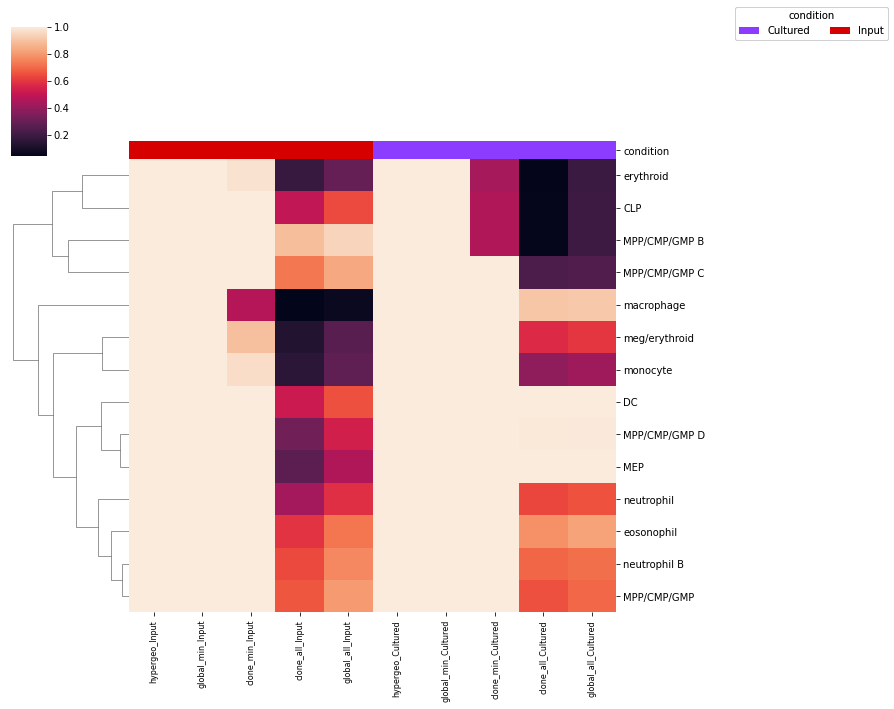

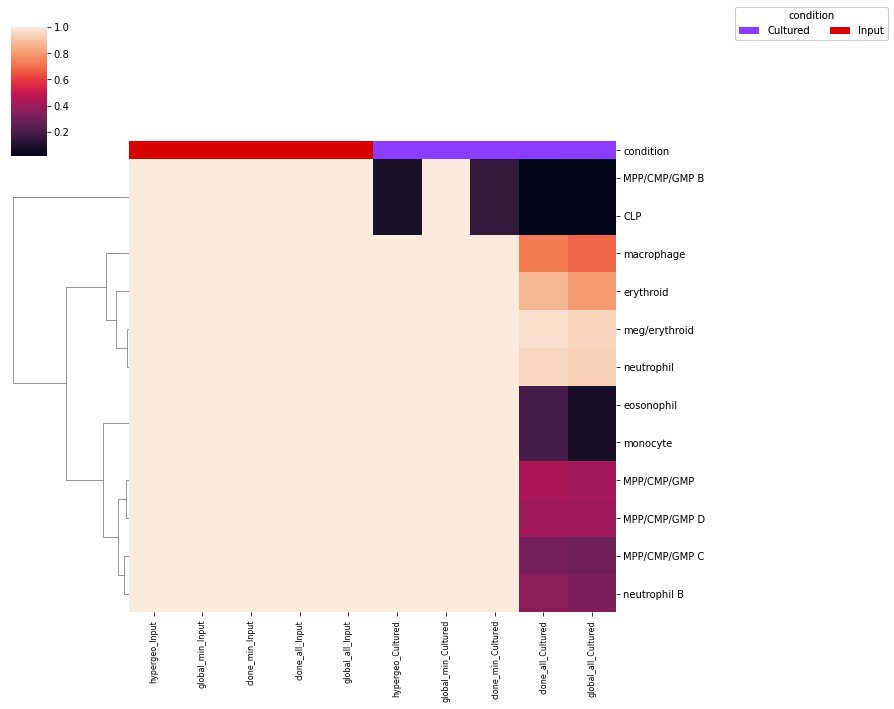

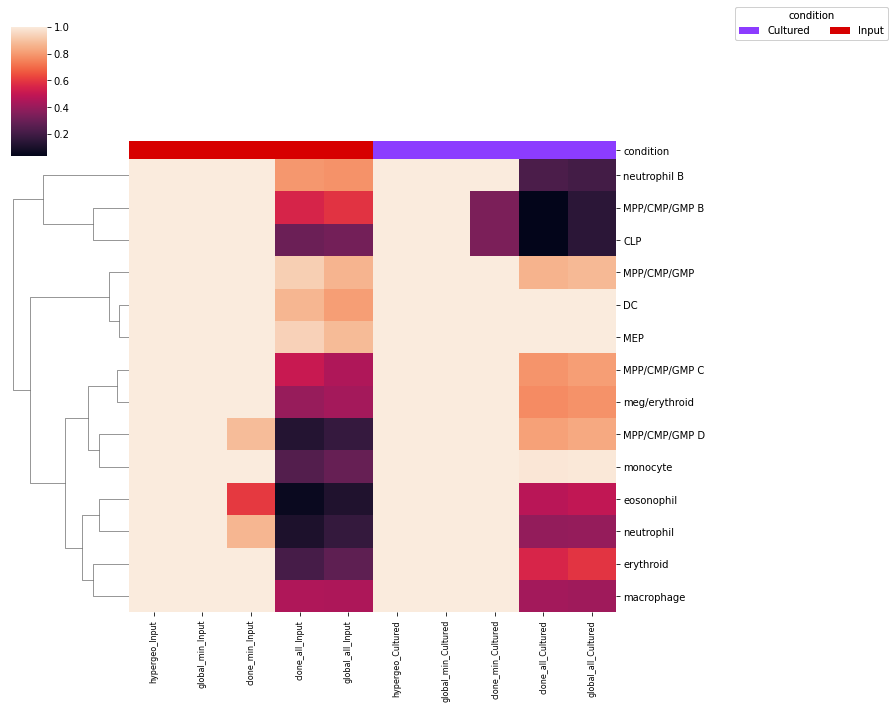

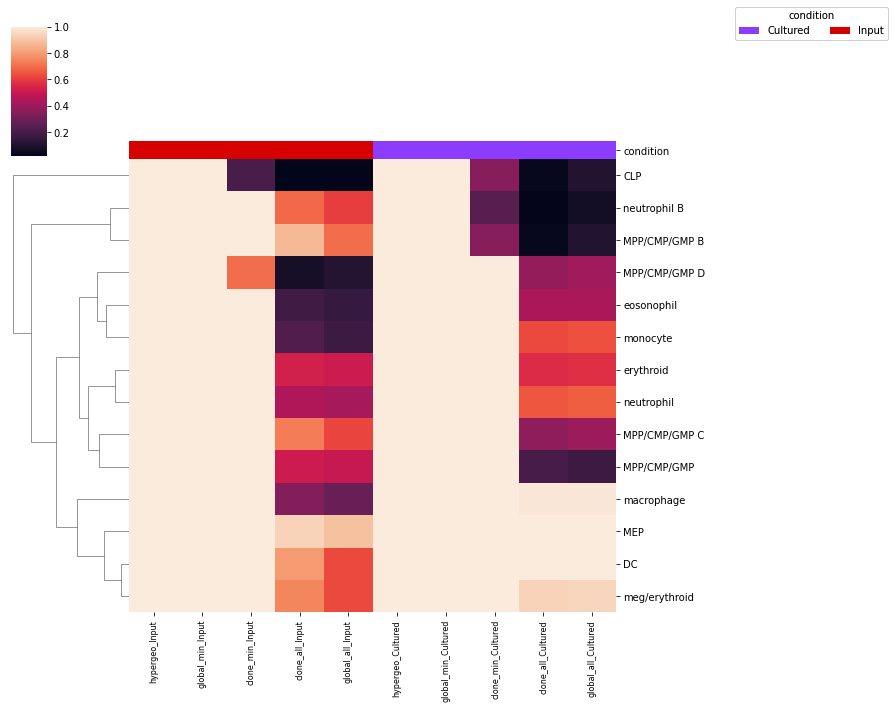

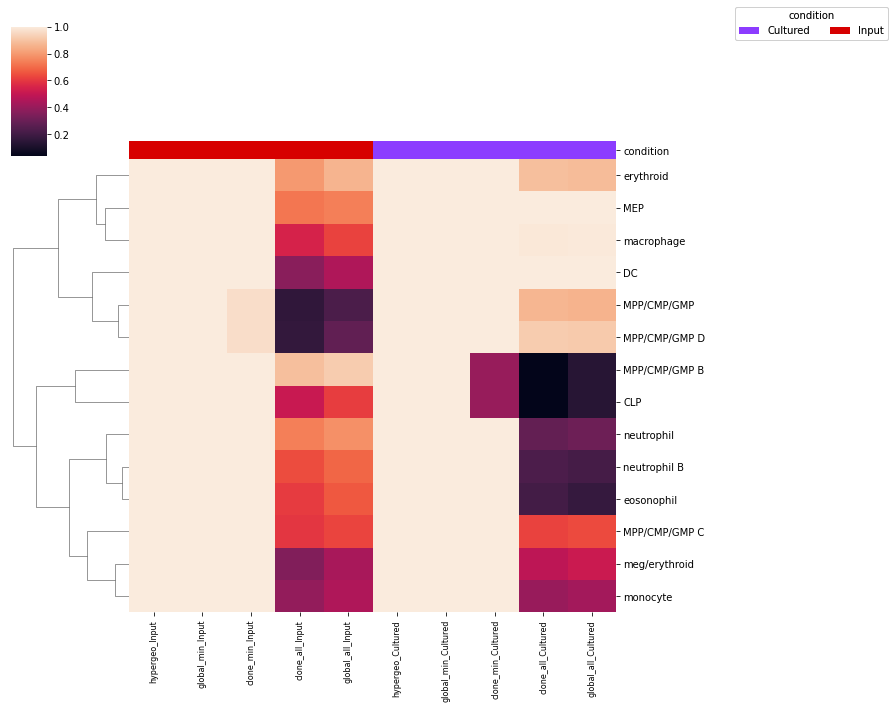

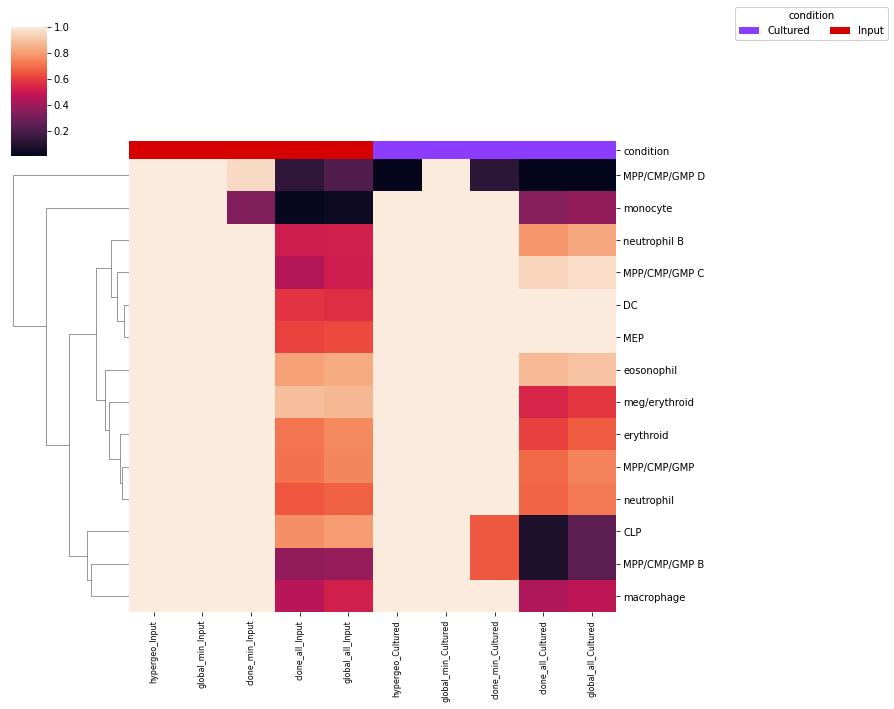

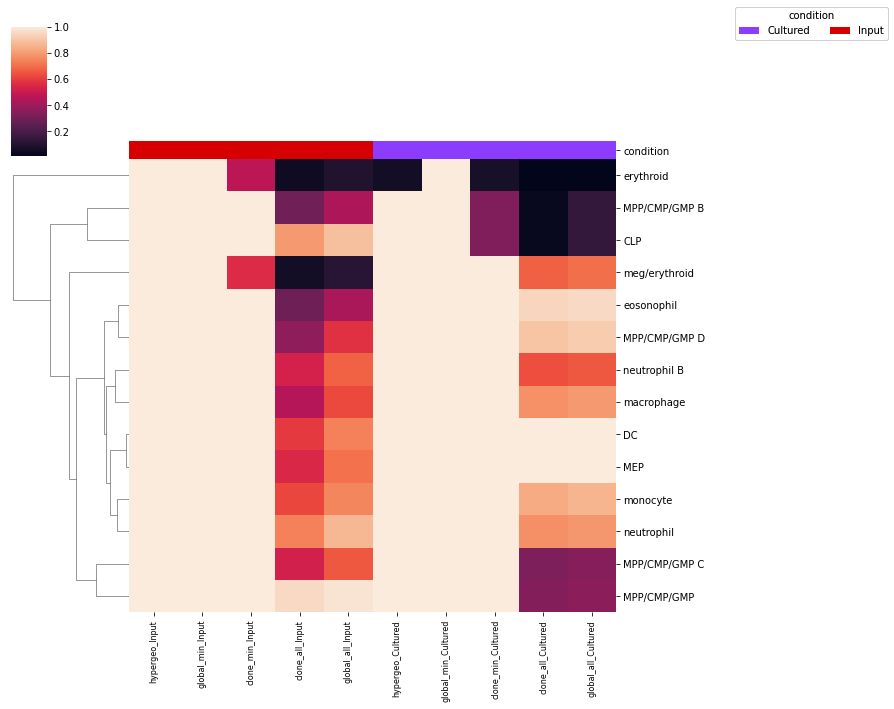

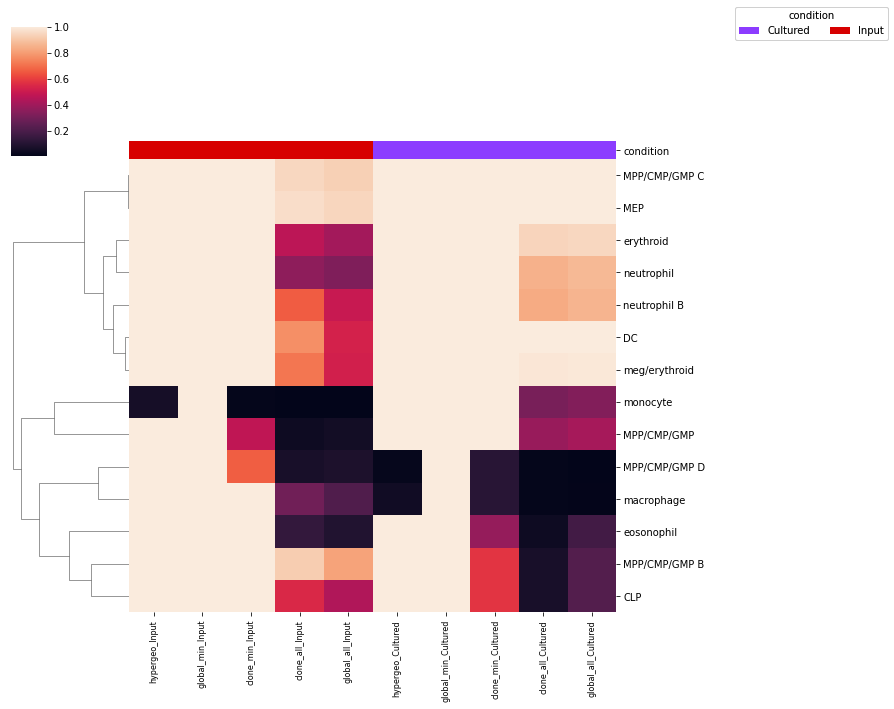

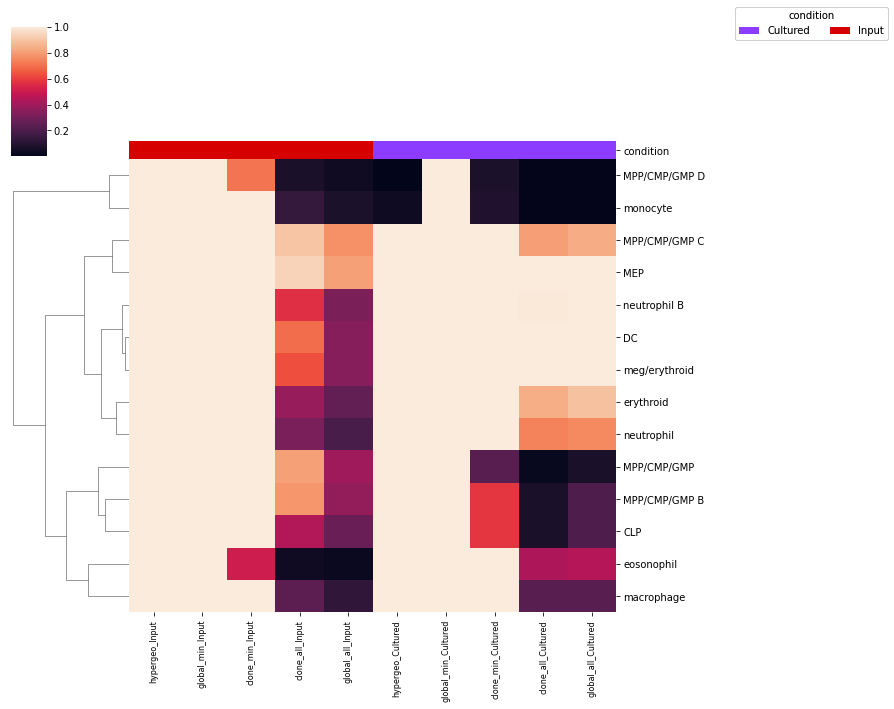

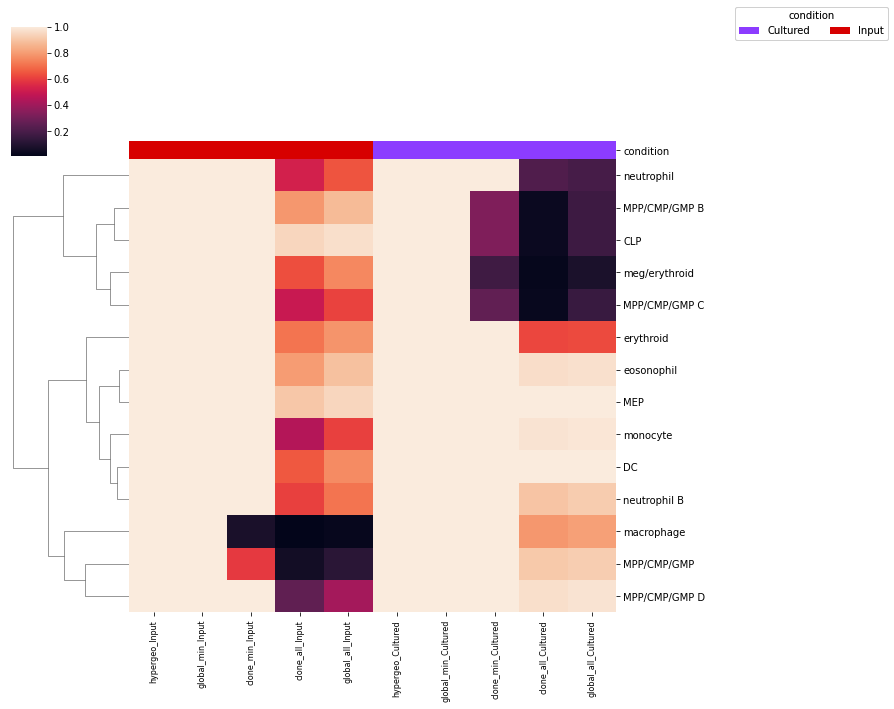

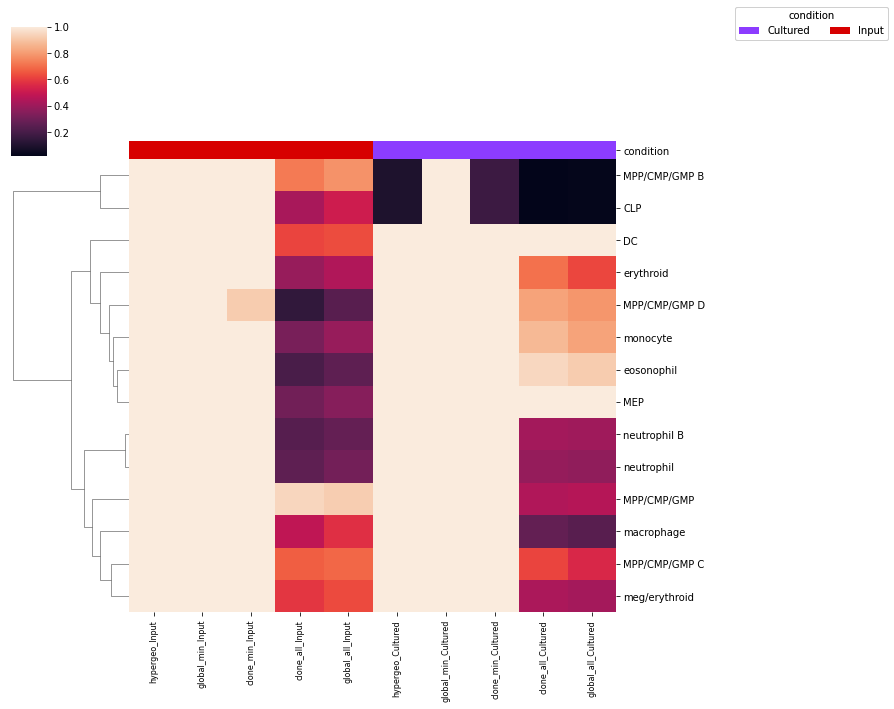

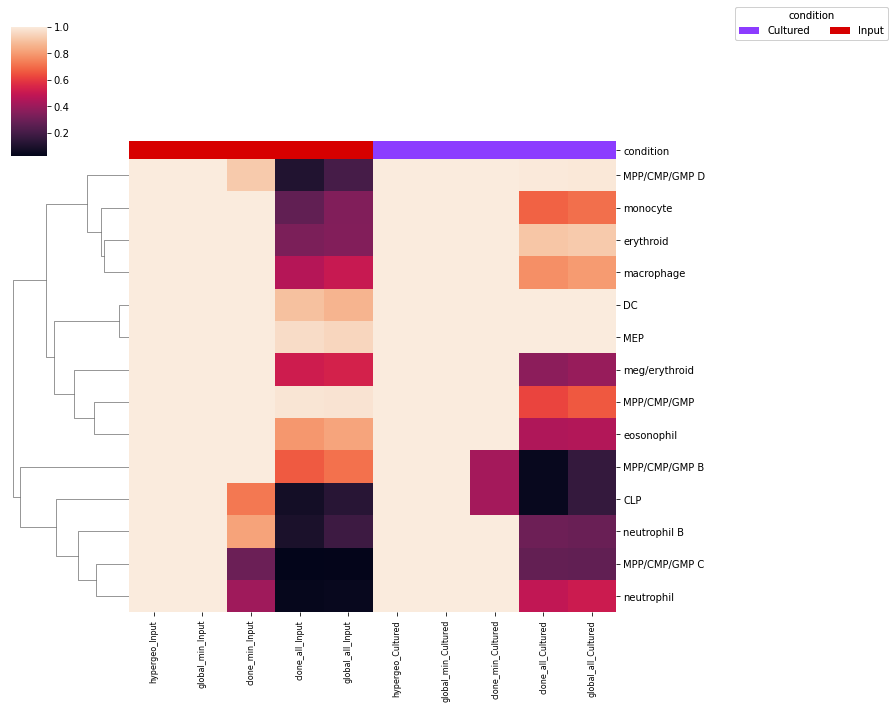

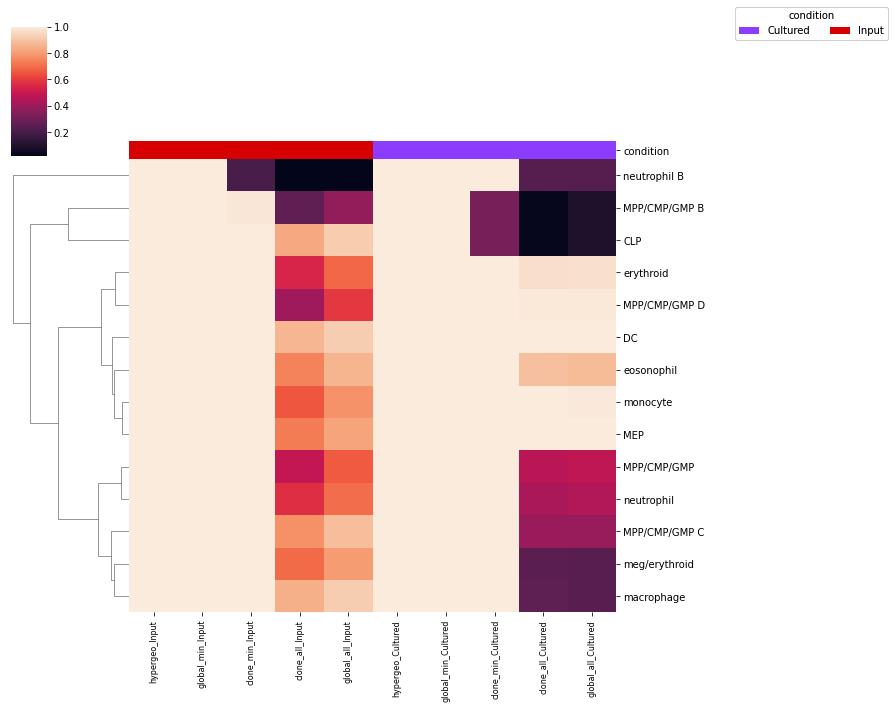

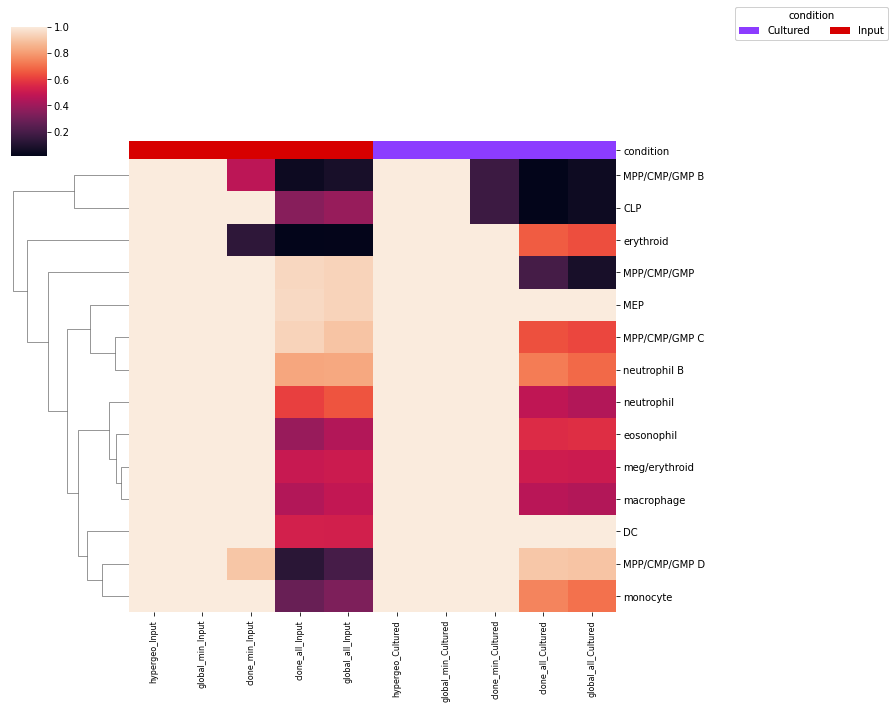

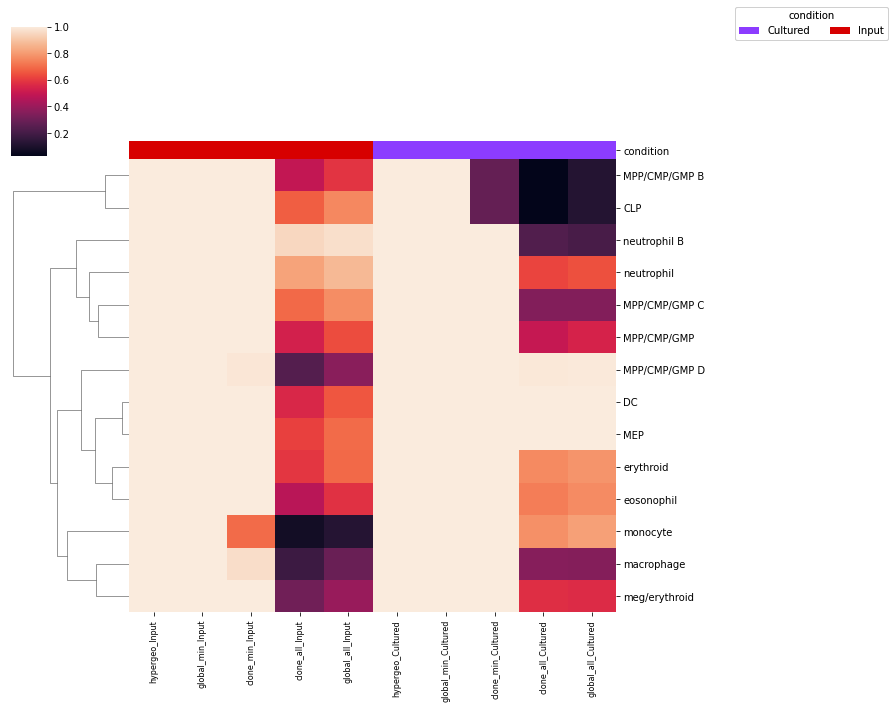

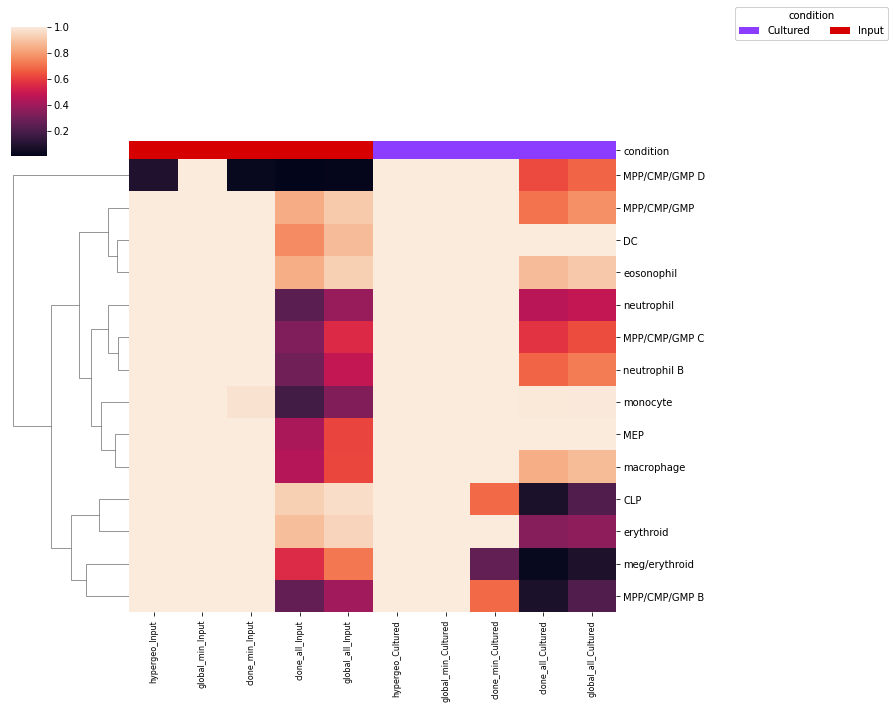

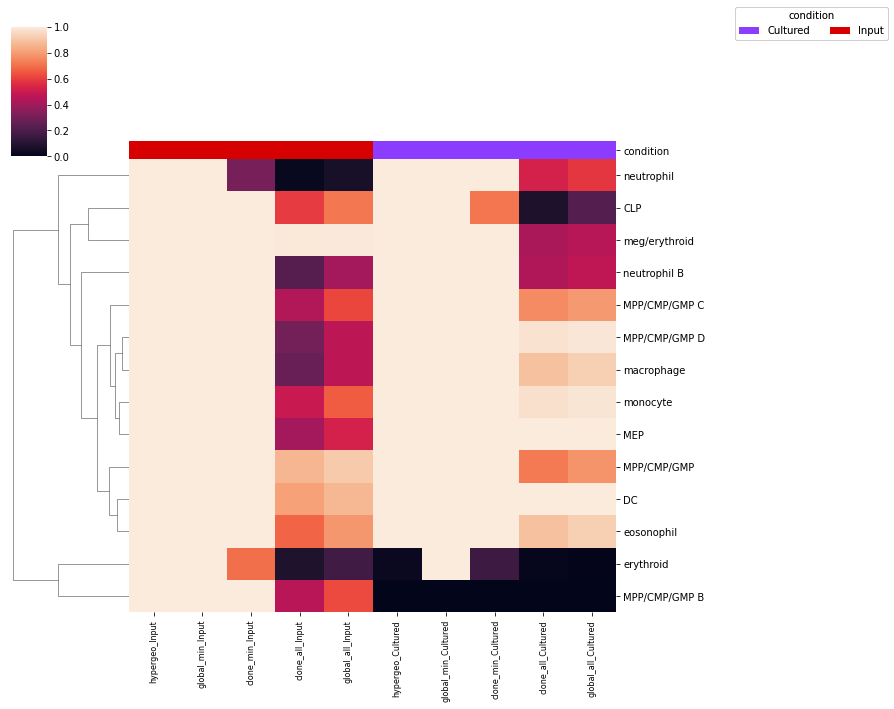

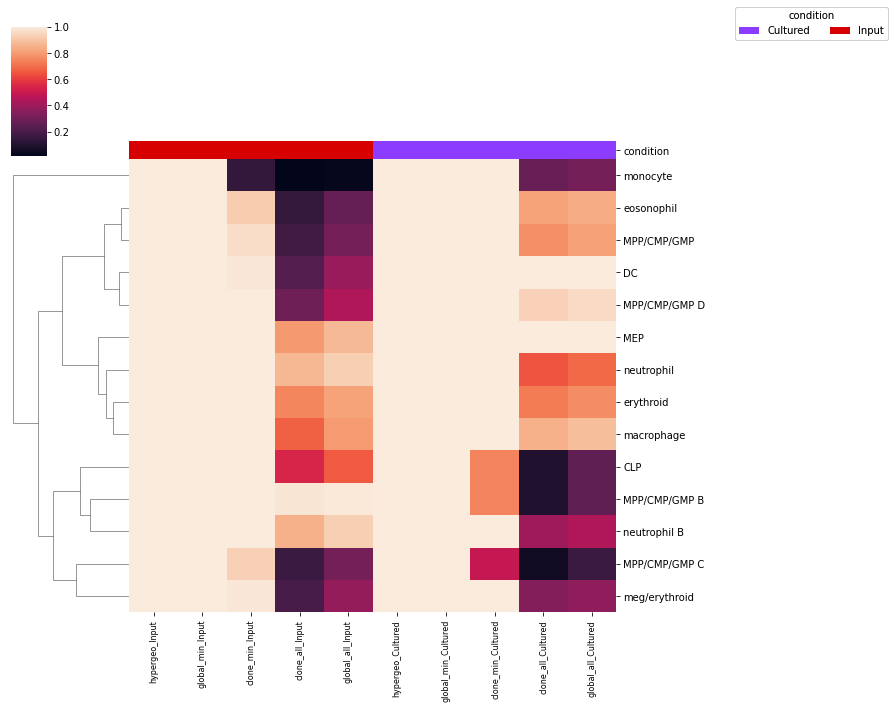

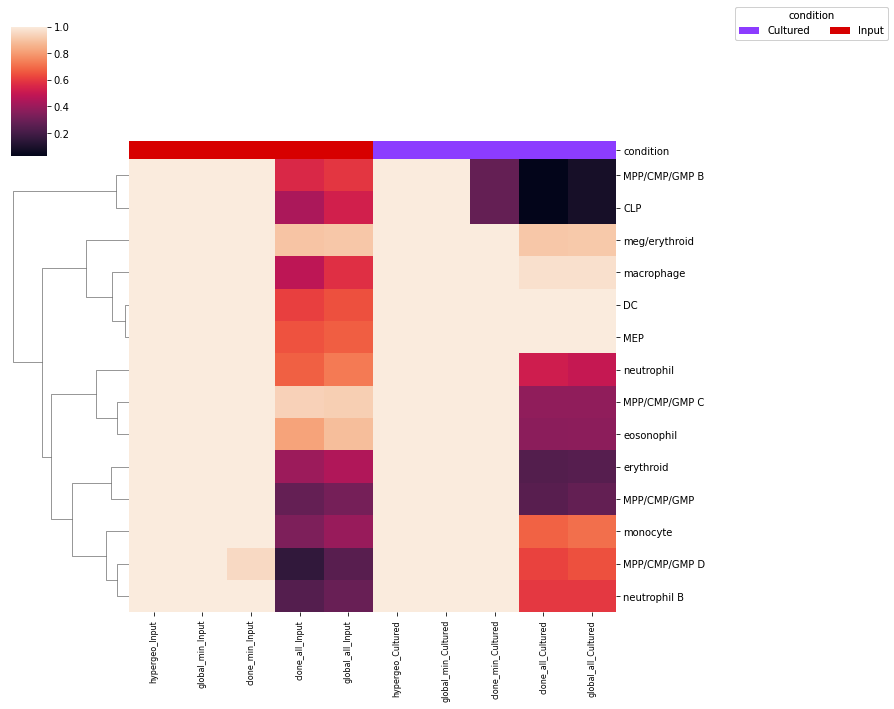

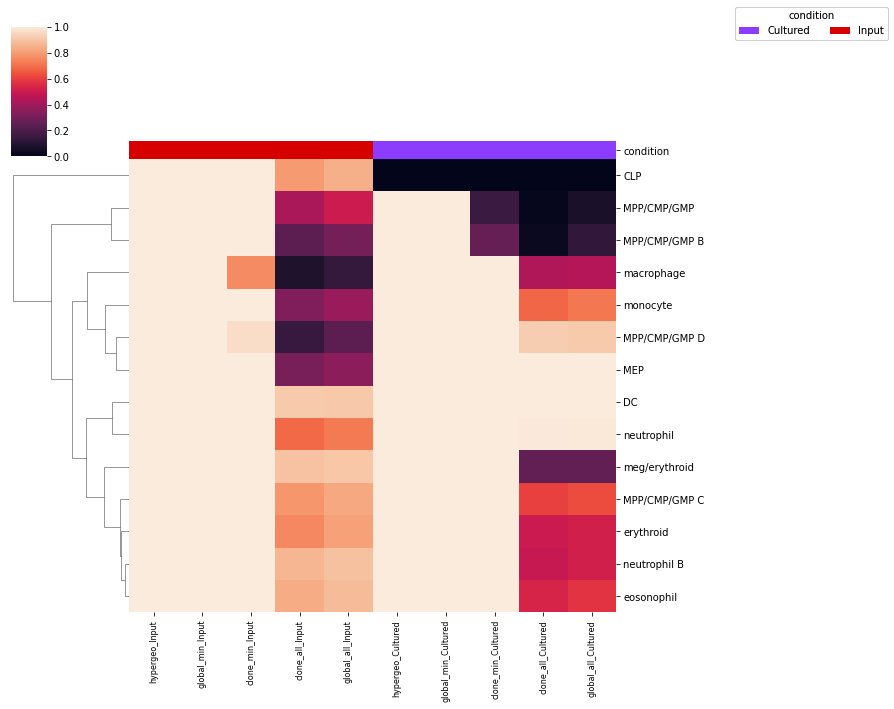

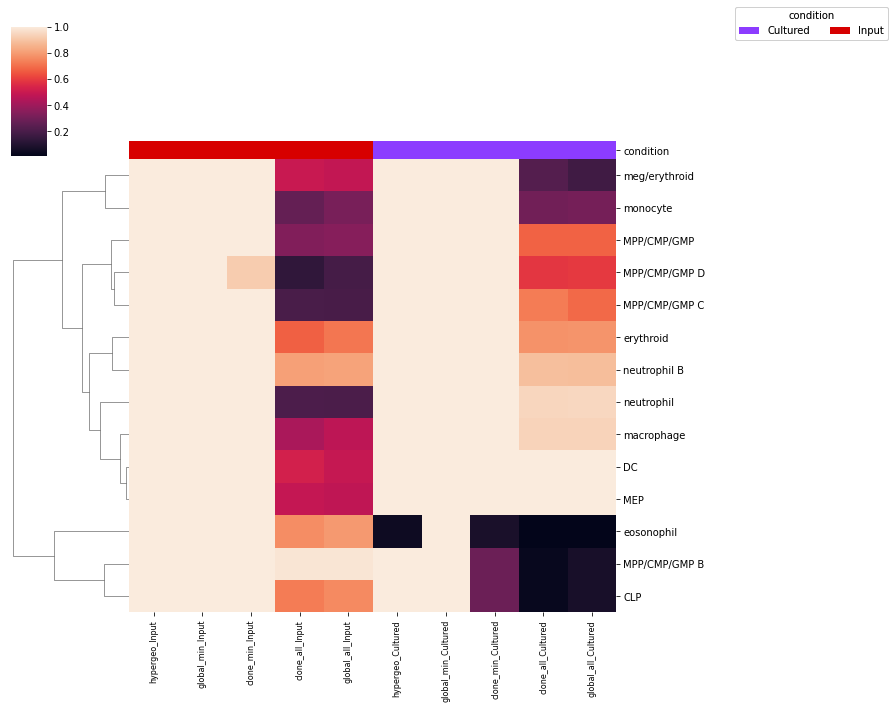

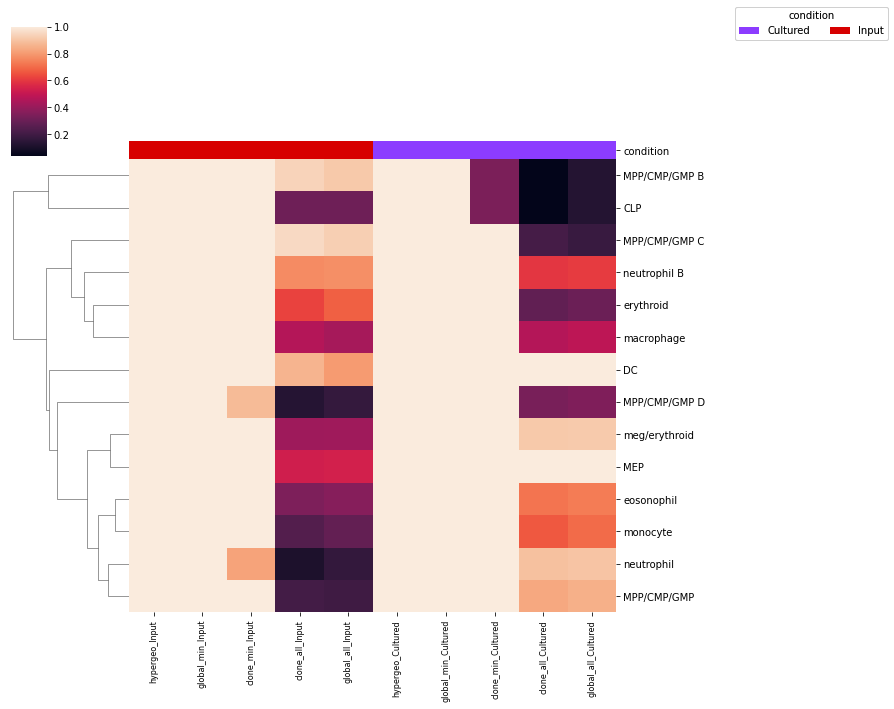

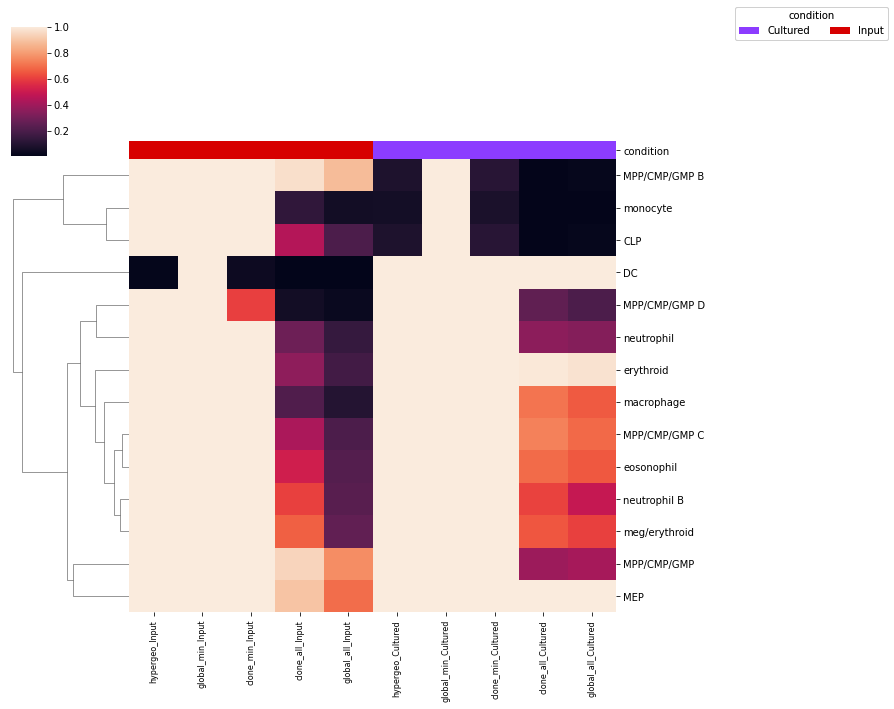

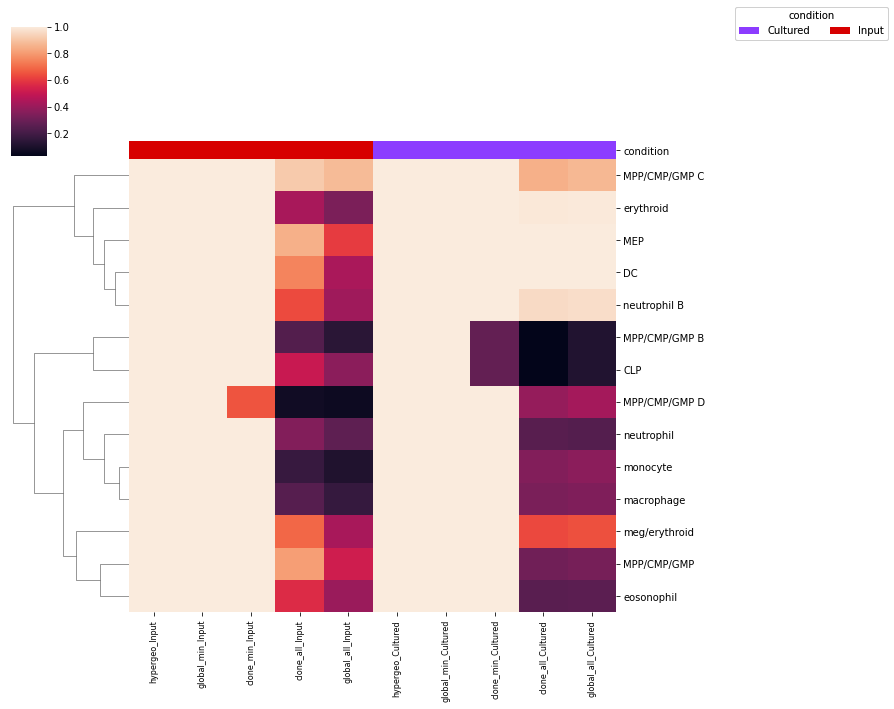

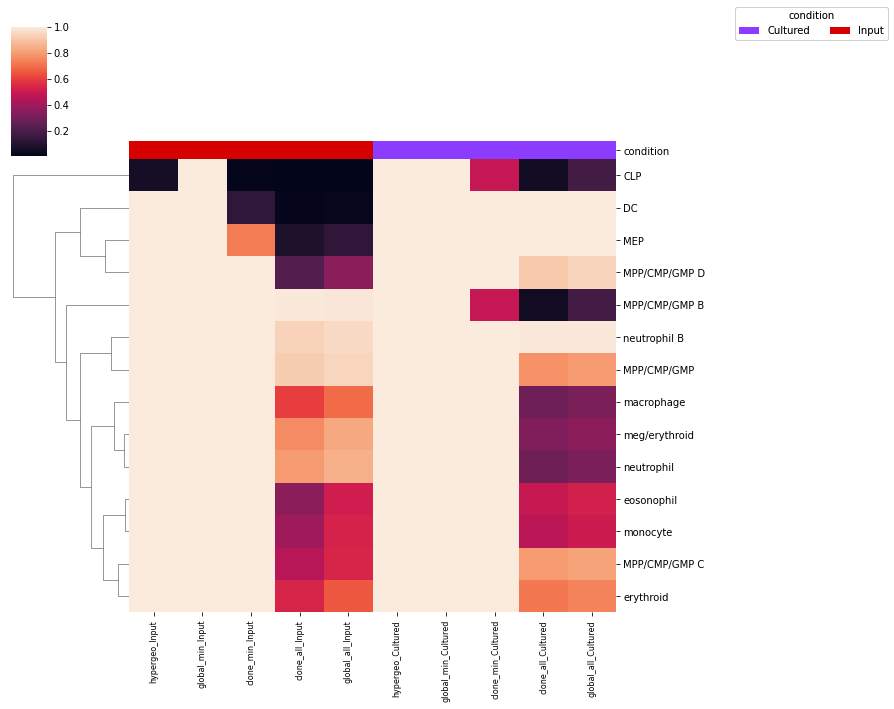

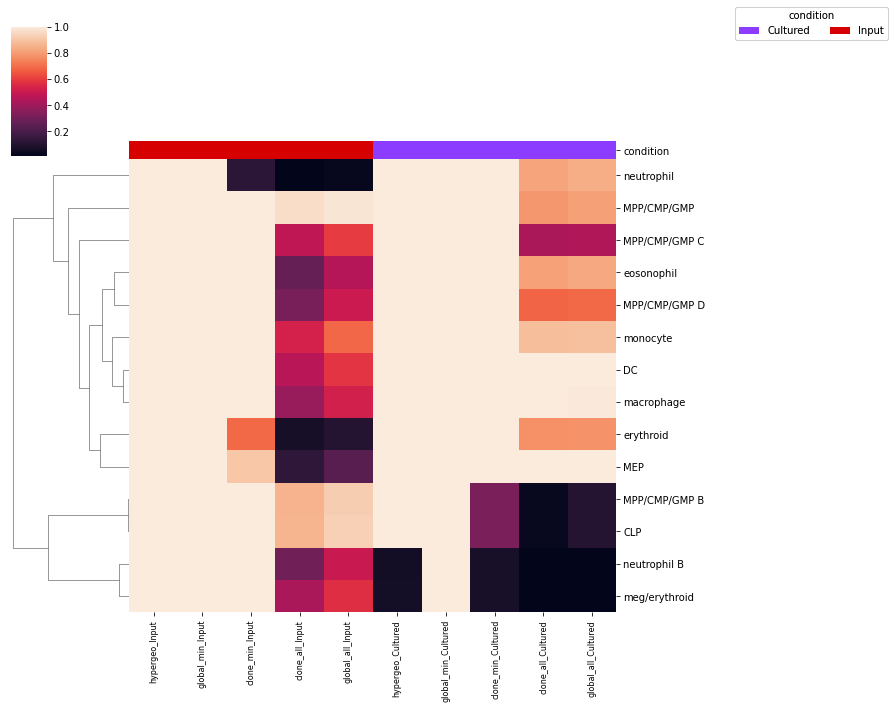

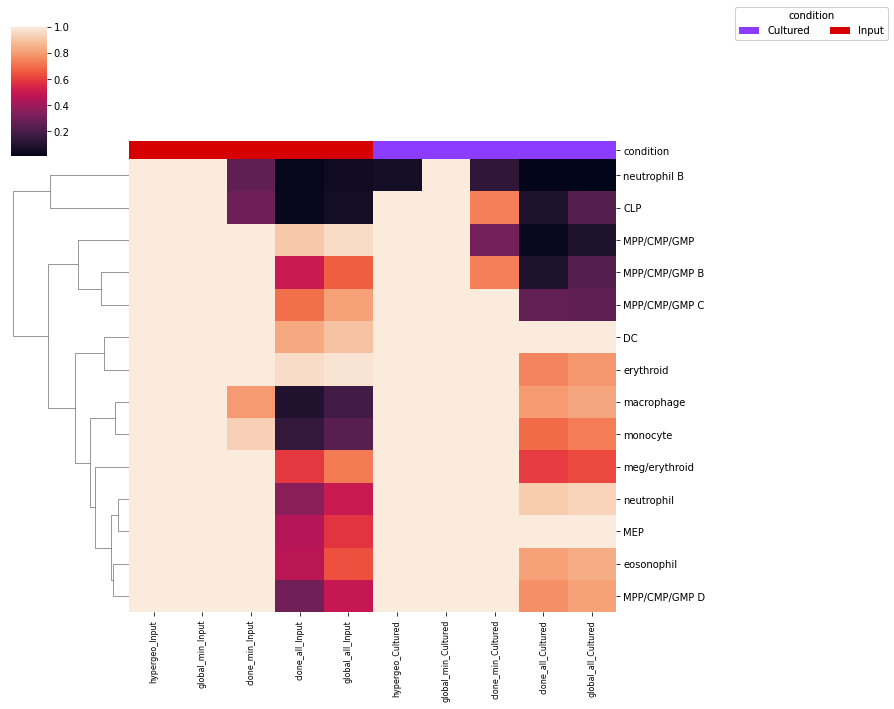

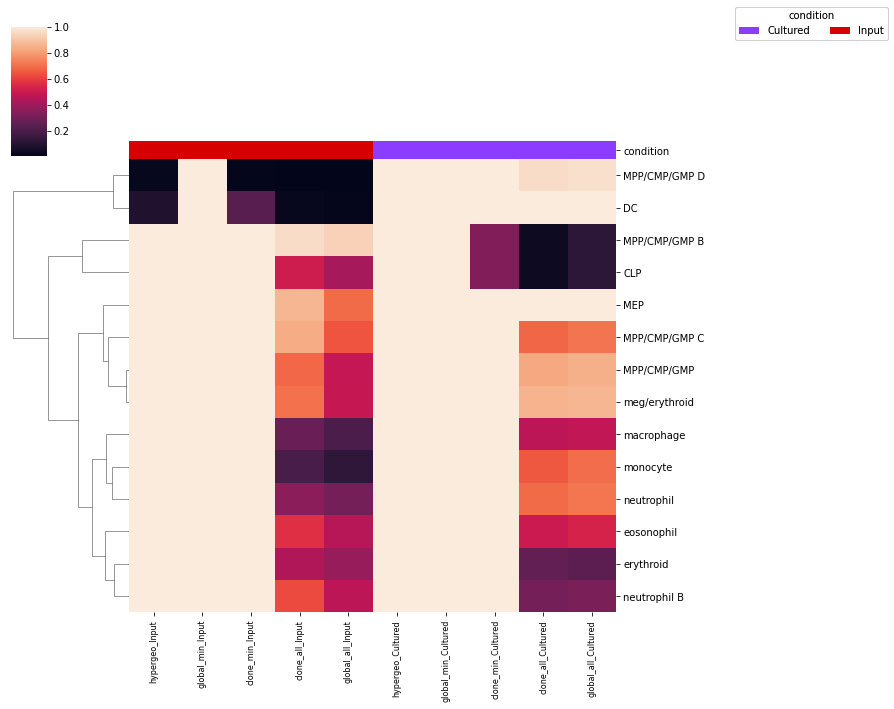

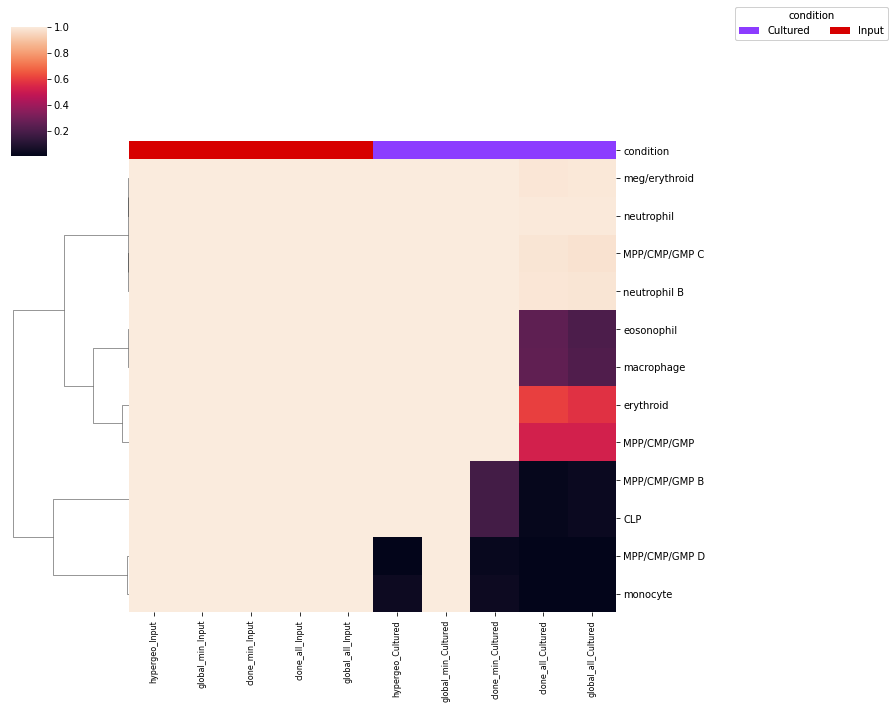

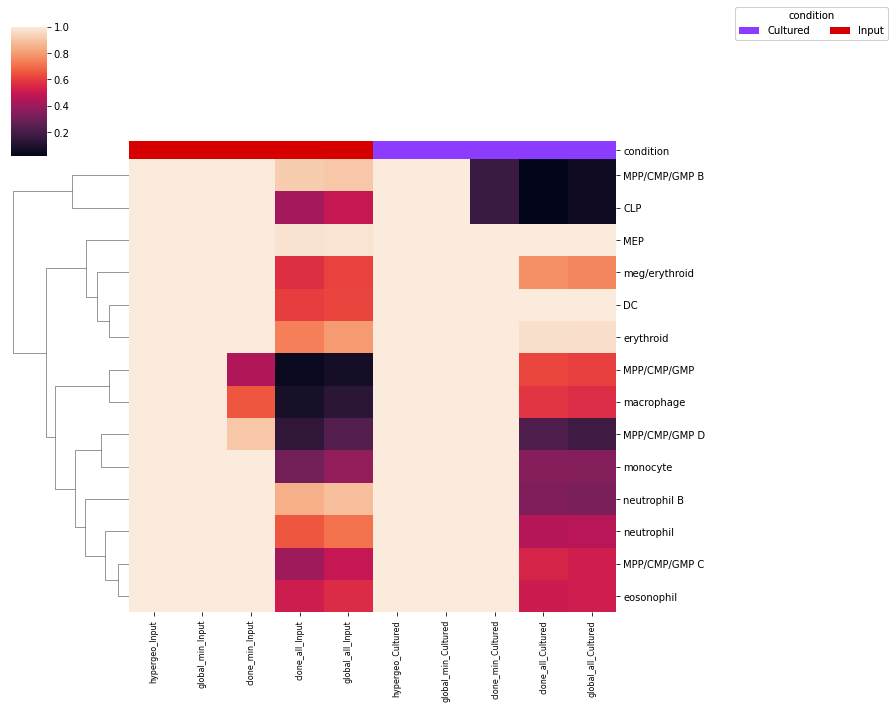

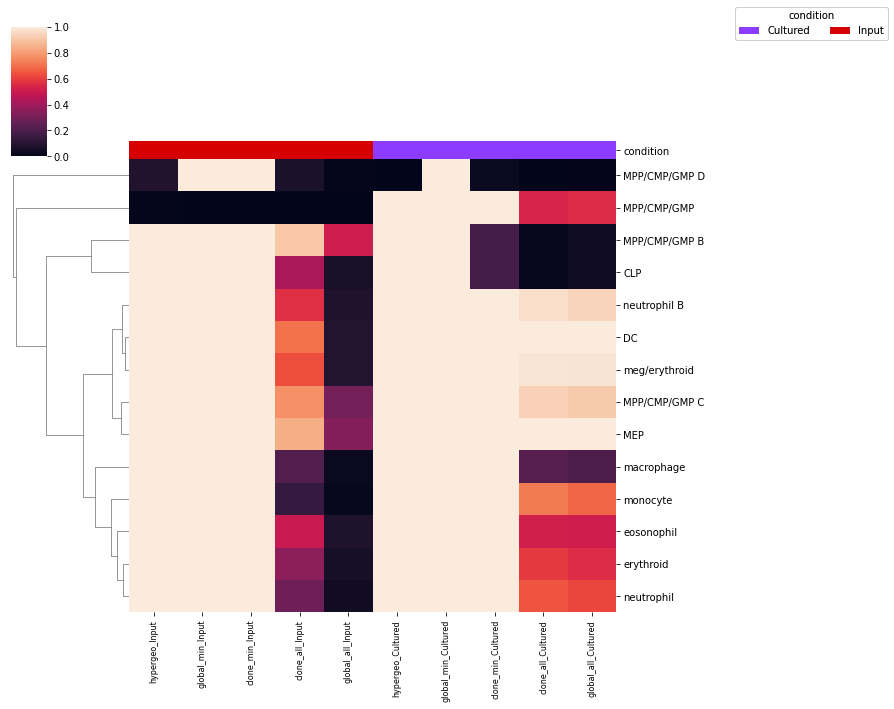

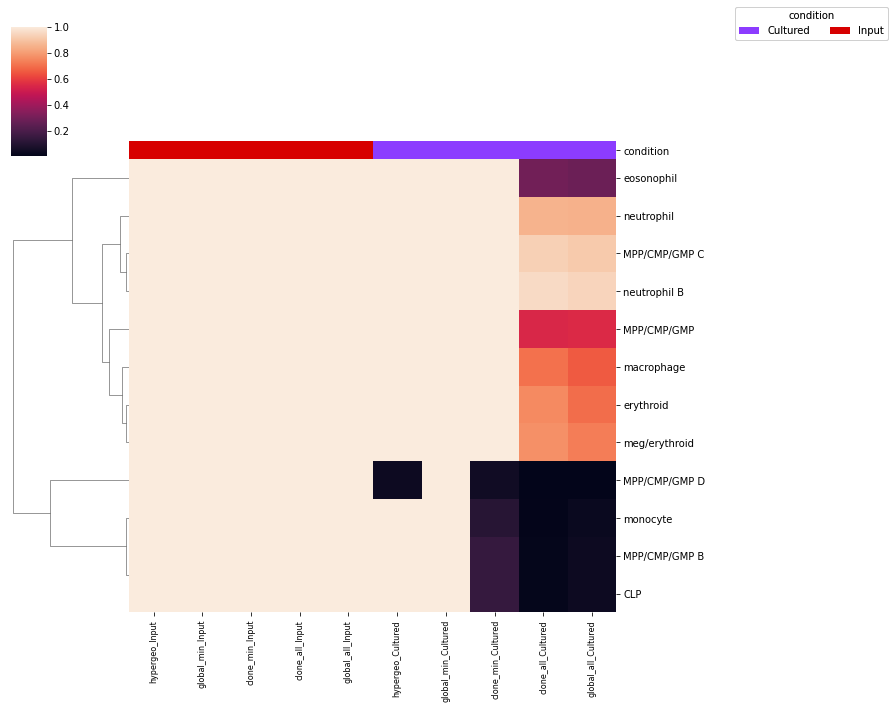

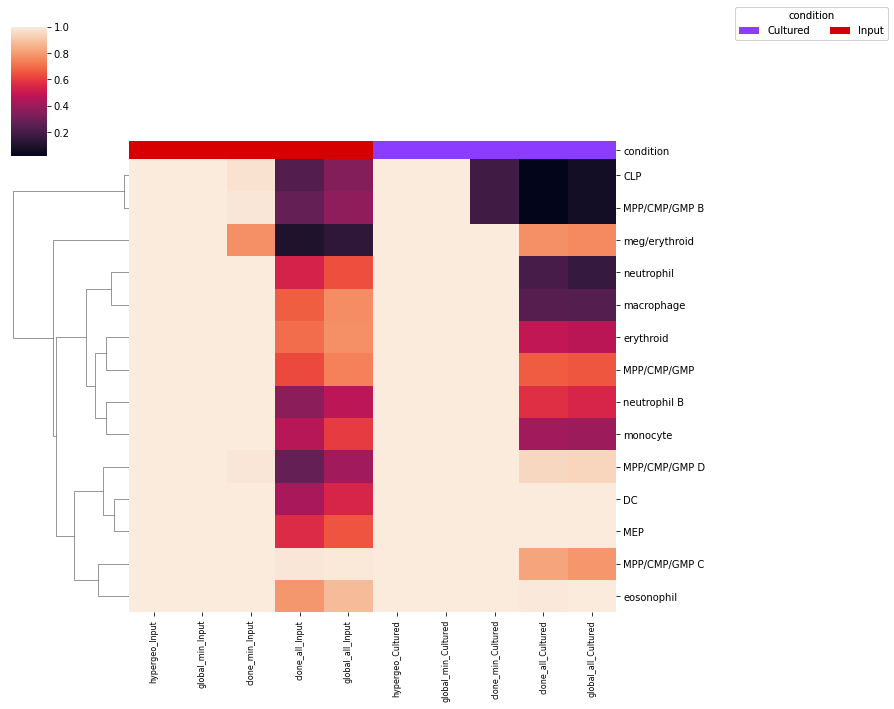

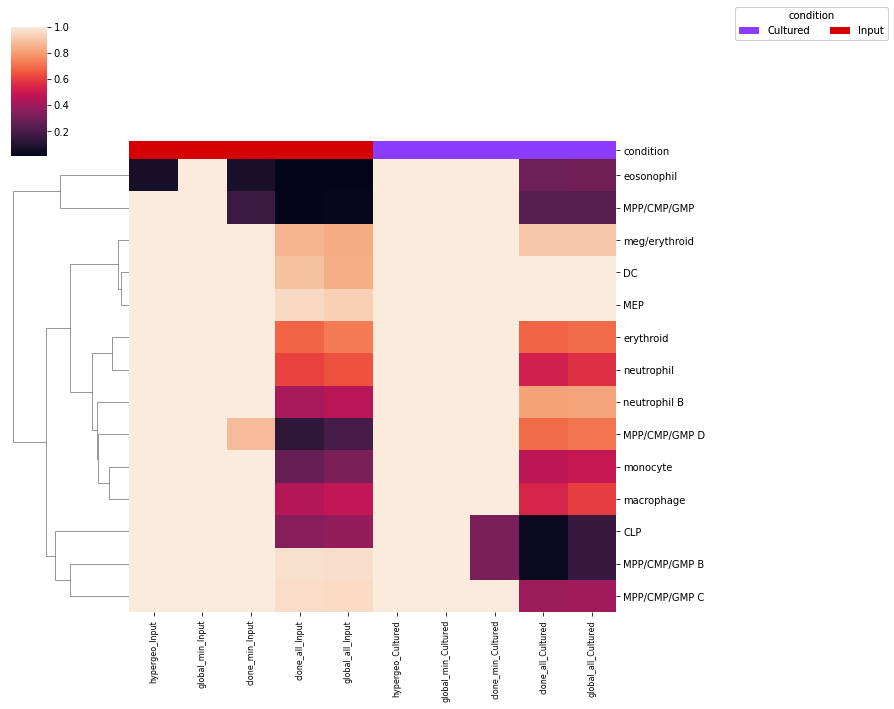

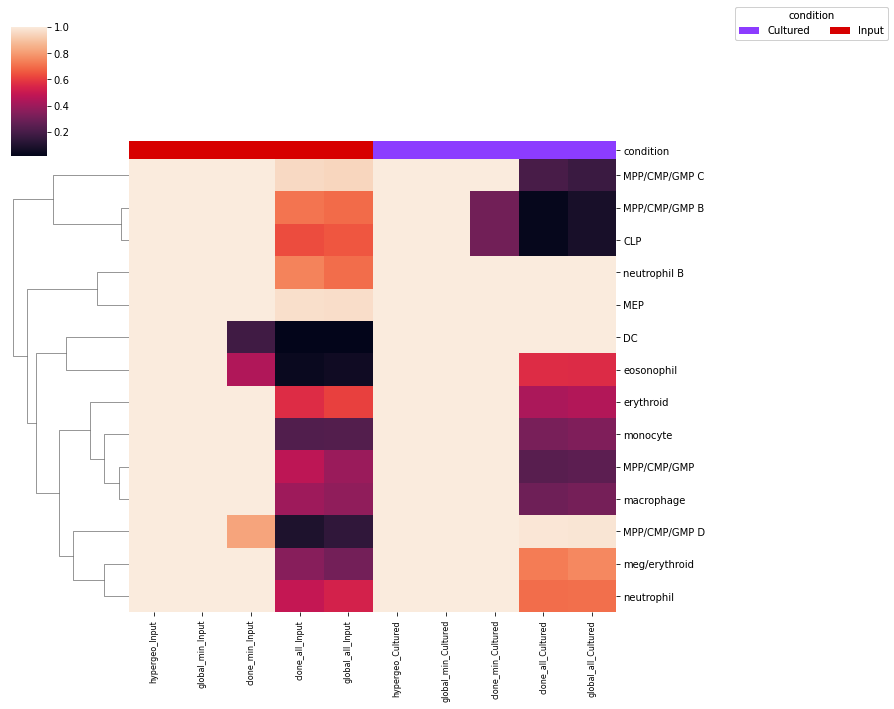

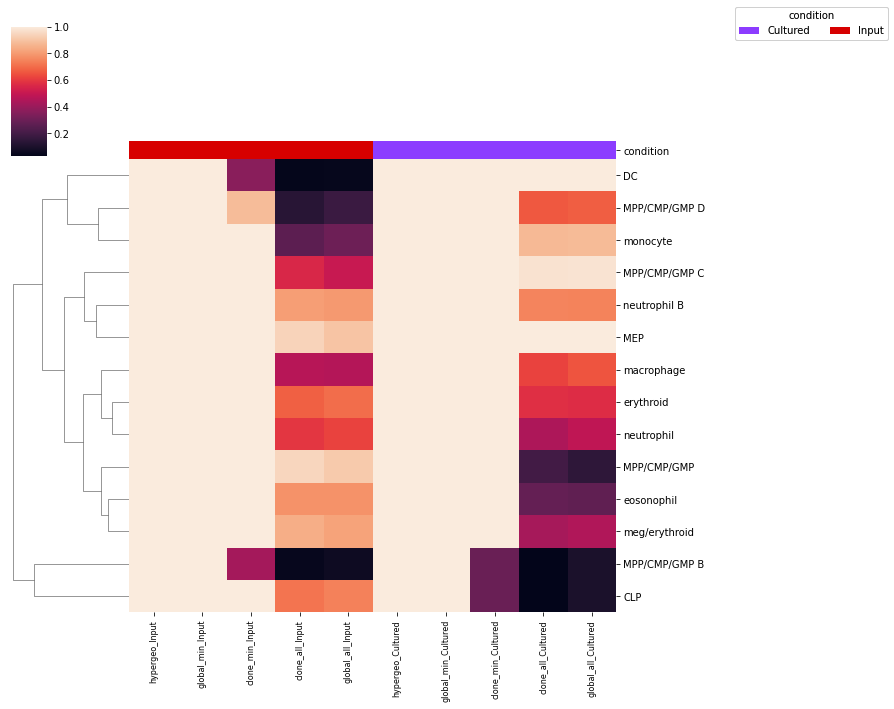

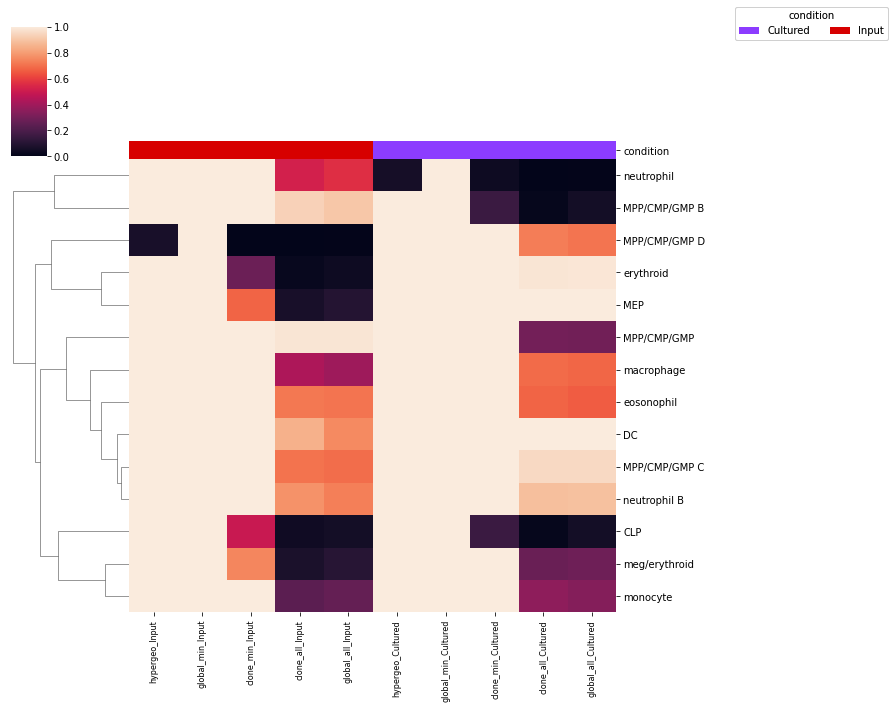

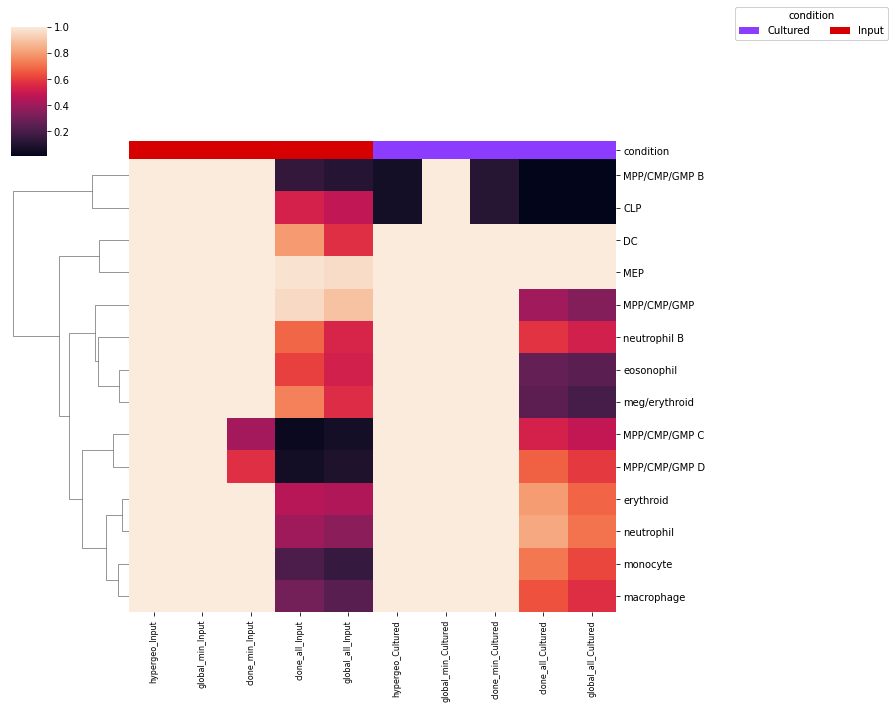

In [15]:
for c_id in cloneIDs:
    run_ind_clone(c_id)

In [ ]:
# clone_d = {}
# clone_d["noIn_hyper"] = noInput_hyper.loc[clone_id]
# clone_d["noIn_shuffle"] = noIn_shuffle_df.loc[noIn_shuffle_df["index"]==clone_id]

# clone_d["input_hyper"] = input_hyper.loc[clone_id]
# clone_d["input_shuffle"] = input_shuffle_df.loc[input_shuffle_df["index"]==clone_id]

# clone_d['noIn_shuffle']

# clone_d['noIn_hyper']

# clustIDs = set(clone_d['input_hyper'].index).union(set(clone_d['noIn_hyper'].index))
# clustIDs = clustIDs.union(set(clone_d['noIn_shuffle']["variable"].values).union(set(clone_d['input_shuffle']["variable"].values)))
# clustIDs

# ## Create p-val table for the clone

# noIn_pval_df = create_pval(clone_d, hyper_key="noIn_hyper",shuffle_key="noIn_shuffle")
# input_pval_df = create_pval(clone_d, hyper_key="input_hyper",shuffle_key="input_shuffle")
# pval_df = pd.merge(input_pval_df, noIn_pval_df, left_index=True, right_index=True, 
#                    how="outer", suffixes=("_Input", "_Cultured"))

# ## Sort clusters by global_min, hypergeo, 
# pval_df = pval_df.fillna(1).sort_values(["global_min_Input", "hypergeo_Input", "clone_min_Input","global_min_Cultured", "hypergeo_Cultured",  "clone_min_Cultured"])
# clone_meta = pd.DataFrame(index=pval_df.columns, columns = ["condition","size"])
# clone_meta["condition"] = ["Input" if "Input" in x else "Cultured" for x in clone_meta.index]
# pval_df

# ch.plot_cluster(pval_df, to_col_clust=False, col_meta=clone_meta[["condition"]])